## Objetivo
Avaliar  a detecção de falha por meio do valor eficaz (RMS) da velocidade segundo norma ABNT

# Níveis gerais de vibração
## Desbalanceamento

In [148]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [149]:
df = pd.read_csv('../data.csv')
print('Amostras: {} \nColunas: {}'.format(df.shape[0], df.shape[1]))

Amostras: 880 
Colunas: 52


In [150]:
def filter_defect(df, defeito):
    # separa apenas amostras com de'feito'
    filtered_df =  df.query("defeito == '{}' or defeito == 'normal'".format(defeito))
    filtered_df.pop('defeito')
    # separa apenas as colunas com RMS da velocidade
    filtered_df = filtered_df[[
        'severidade',   'fundamental', 
         'ax1_vel_rms',  
         'ax2_vel_rms', 
        'rad1_vel_rms', 
        'rad2_vel_rms', 
         'tg1_vel_rms',  
         'tg2_vel_rms' 
    ]]
    # simplifica o nome dos eixos
    filtered_df = filtered_df.rename(columns={
         'ax1_vel_rms': 'ax1',  
         'ax2_vel_rms': 'ax2', 
        'rad1_vel_rms': 'rad1', 
        'rad2_vel_rms': 'rad2', 
         'tg1_vel_rms': 'tg1',  
         'tg2_vel_rms': 'tg2',
         'ax1_rms': 'ax1',  
         'ax2_rms': 'ax2', 
        'rad1_rms': 'rad1', 
        'rad2_rms': 'rad2', 
         'tg1_rms': 'tg1',  
         'tg2_rms': 'tg2',
    })

    return filtered_df

df_desbal = filter_defect(df, 'desbalanceamento')
df_desbal

,severidade,fundamental,ax1,ax2,rad1,rad2,tg1,tg2
498,10.0,13.6272,3.709297,1.001809,0.921058,0.210116,0.160228,4.237119
499,10.0,14.2284,3.924583,1.033236,1.021624,0.218205,0.179018,4.583939
500,10.0,15.4308,3.378807,1.113301,1.058142,0.219163,0.231928,3.498109
501,10.0,16.2324,2.950474,1.035870,1.035508,0.202693,0.244354,2.930913
502,10.0,16.8336,3.287712,0.869502,1.082875,0.178001,0.317970,3.090470
...,...,...,...,...,...,...,...,...
875,0.0,56.7132,1.362673,0.657733,2.008915,0.130578,0.527572,0.981479
876,0.0,57.5148,1.584103,0.480961,2.029893,0.099970,0.558485,0.969856
877,0.0,58.3164,1.745069,0.399143,2.111434,0.098966,0.534440,1.029314
878,0.0,59.1180,1.746503,0.339588,2.174394,0.089324,0.525599,1.074776


In [151]:
VALUE = 'vibração RMS (mm/s)'
ROTACAO = 'rotação (Hz)'
DESBALANCEAMENTO = 'desbalanceamento (g)'

def select_max(df_filtered):
    # encontra o valor máximo entre todos os RMS
    max_rms = df_filtered.drop(['fundamental', 'severidade'], axis=1).max(axis=1)

    # revela o eixo onde há o maior RMS
    eixo = []
    for i in df_filtered.index:
        for col in df_filtered.columns:
            if df_filtered.loc[i, col] == max_rms[i]:
                eixo.append(col) 

    # cria o novo Dataframe com os máximos
    df_max = df_filtered[['severidade', 'fundamental']]
    df_max.rename(columns={'fundamental': ROTACAO}, inplace=True)
    df_max['eixo'] = eixo
    df_max[VALUE] = max_rms

    return df_max


df_desbal_max = select_max(df_desbal)
df_desbal_max.rename(columns={'severidade': DESBALANCEAMENTO}, inplace=True)

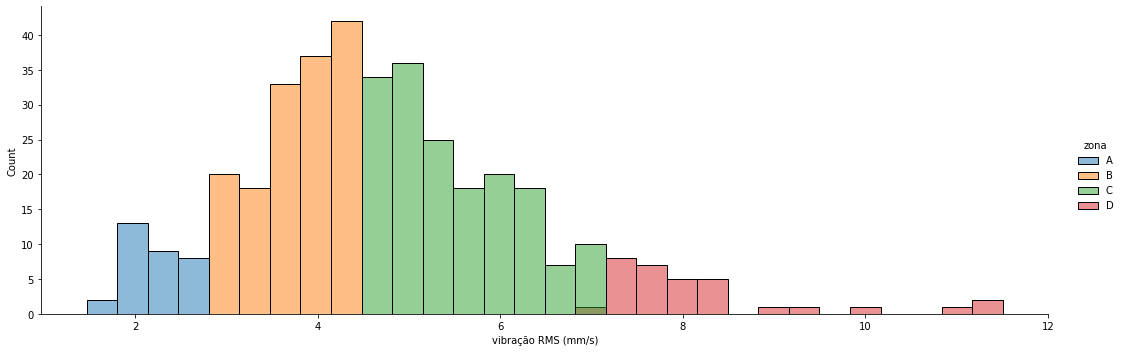

In [153]:
sns.displot(data=df_desbal_max, x=VALUE, hue='zona',
            aspect=3, bins=30);

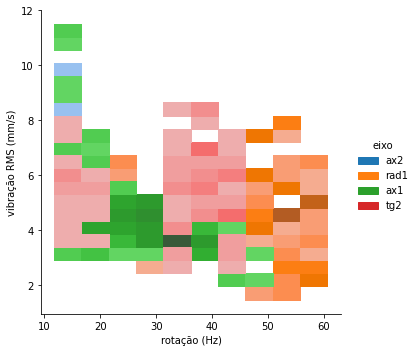

In [154]:
sns.displot(data=df_desbal_max, hue='eixo', y=VALUE, x=ROTACAO);

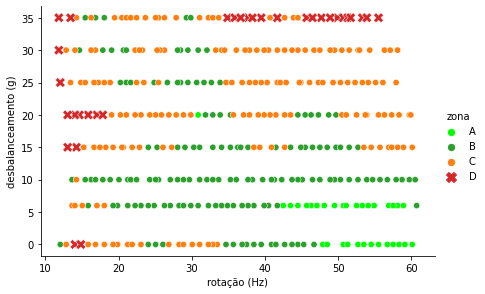

In [155]:
sns.relplot(
    data=df_desbal_max, height=4, aspect=1.5,
    y=DESBALANCEAMENTO, x=ROTACAO, size='zona', sizes=[40, 40, 40, 100], markers='oooX', style='zona',
    hue='zona', palette=paleta
);  

* **Zona A**: valores de vibração recomendados para máquinas novas ou recentemente comissionadas;

* **Zona B**:  consideradas  aceitáveis para operação contínua para longo período de operação, sem restrição;

* **Zona C**:  consideradas insatisfatórias para a operação contínua por um longo período. Geralmente, podem continuar operando por um período limitado de tempo e deve-se programar sua correção;

* **Zona D**: indicam possibilidades de danos em curto prazo

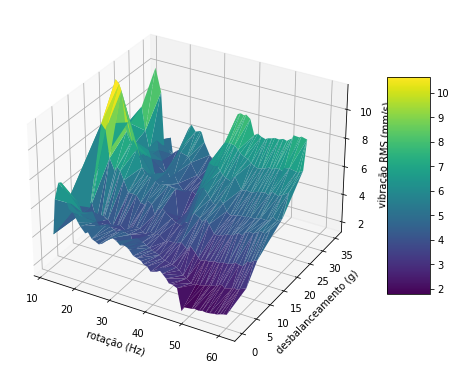

In [156]:
from mpl_toolkits import mplot3d

def plot_surface(df_max, defect_name):
    # Make the plot
    fig = plt.figure(figsize=(8,8))
    ax = fig.gca(projection='3d')
    surf = ax.plot_trisurf(
        df_max[ROTACAO], df_max[defect_name], df_max[VALUE], 
        cmap=plt.cm.viridis, linewidth=0.1
    )
    ax.set_xlabel(ROTACAO)
    ax.set_ylabel(defect_name)
    ax.set_zlabel(VALUE);

    # to Add a color bar which maps values to colors.
    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.show()

plot_surface(df_desbal_max, DESBALANCEAMENTO)

Nível de vibração RMS


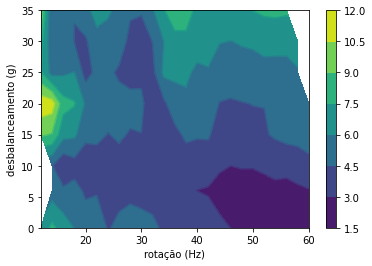

In [157]:
def plota_niveis(df_max, defect_name):
    df_pivot = df_max.drop(['eixo', 'zona'], axis=1).copy(deep=True)
    df_pivot[ROTACAO] = df_pivot[ROTACAO].apply(round)//2*2
    df_pivot = df_pivot.groupby([ROTACAO, defect_name]).max()
    df_pivot = df_pivot.reset_index()
    df_pivot = df_pivot.pivot(index=ROTACAO, columns=defect_name, values=VALUE)


    X, Y = np.meshgrid(df_pivot.index, df_pivot.columns)
    Z= df_pivot.T

    fig, ax = plt.subplots()
    CS = ax.contour(X, Y, Z, levels=8)
    cp = ax.contourf(X, Y, Z)
    fig.colorbar(cp)
    ax.set_xlabel(ROTACAO)
    ax.set_ylabel(defect_name)
    # ax.clabel(CS, inline=1, fontsize=10)
    print('Nível de vibração RMS');

plota_niveis(df_desbal_max, DESBALANCEAMENTO)

# Desalinhamento Vertical

In [158]:
df_des_ver = filter_defect(df, 'desalinhamento_vertical')
df_des_ver_max = select_max(df_des_ver)

DESALINHAMENTO_VERTICAL = 'desalinhamento vertical (mm)' 
df_des_ver_max.rename(columns={'severidade': DESALINHAMENTO_VERTICAL}, inplace=True)
df_des_ver_max

,desalinhamento vertical (mm),rotação (Hz),eixo,vibração RMS (mm/s)
197,0.51,12.2244,ax2,9.169538
198,0.51,12.8256,ax2,6.954411
199,0.51,14.6292,ax1,5.835915
200,0.51,15.8316,ax1,4.914379
201,0.51,16.6332,ax1,5.453138
...,...,...,...,...
875,0.00,56.7132,rad1,2.008915
876,0.00,57.5148,rad1,2.029893
877,0.00,58.3164,rad1,2.111434
878,0.00,59.1180,rad1,2.174394


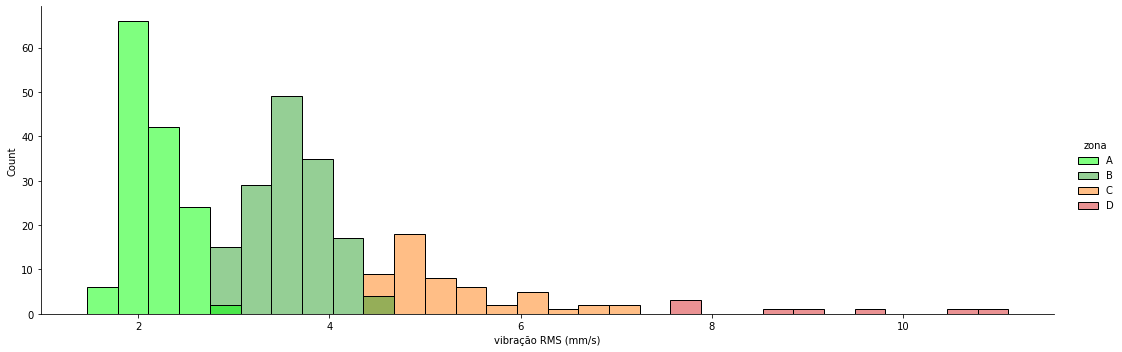

In [159]:
df_des_ver_max['zona'] = df_des_ver_max[VALUE].apply(zona_NBR10082)
df_des_ver_max = df_des_ver_max.sort_values(VALUE)
sns.displot(data=df_des_ver_max, x=VALUE, hue='zona', aspect=3, bins=30, palette=paleta);

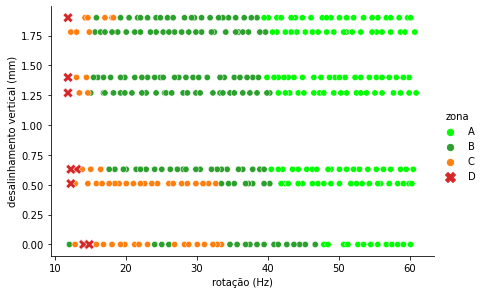

In [160]:
sns.relplot(
    data=df_des_ver_max, height=4, aspect=1.5,
    y=DESALINHAMENTO_VERTICAL, x=ROTACAO, size='zona', sizes=[40, 40, 40, 100], markers='oooX', style='zona',
    hue='zona', palette=paleta,
);  

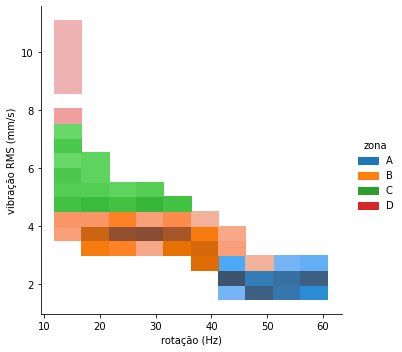

In [161]:
sns.displot(data=df_des_ver_max, hue='zona', y=VALUE, x=ROTACAO);

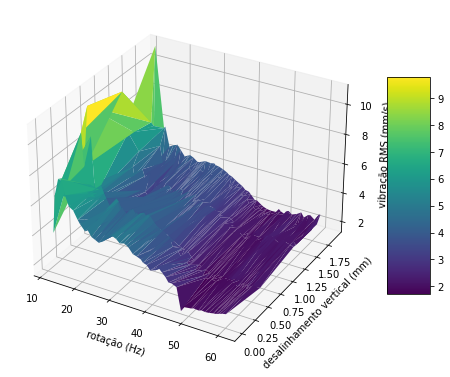

Nível de vibração RMS


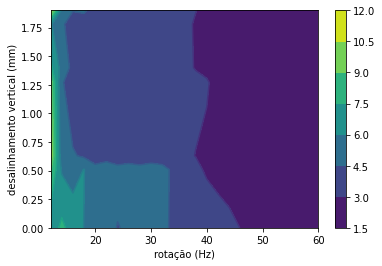

In [162]:
plot_surface(df_des_ver_max, DESALINHAMENTO_VERTICAL)
plota_niveis(df_des_ver_max, DESALINHAMENTO_VERTICAL)

# Desbalanceamento Horizontal

In [163]:
df_des_hor = filter_defect(df, 'desalinhamento_horizontal')
df_des_hor_max = select_max(df_des_hor)

DESALINHAMENTO_HORIZONTAL = 'desalinhamento horizontal (mm)' 
df_des_hor_max.rename(columns={'severidade': DESALINHAMENTO_HORIZONTAL}, inplace=True)
df_des_hor_max

,desalinhamento horizontal (mm),rotação (Hz),eixo,vibração RMS (mm/s)
0,0.5,12.0240,ax2,6.757012
1,0.5,13.2264,ax2,5.381334
2,0.5,14.2284,ax2,5.085044
3,0.5,15.0300,ax2,5.342766
4,0.5,16.0320,ax2,5.004467
...,...,...,...,...
875,0.0,56.7132,rad1,2.008915
876,0.0,57.5148,rad1,2.029893
877,0.0,58.3164,rad1,2.111434
878,0.0,59.1180,rad1,2.174394


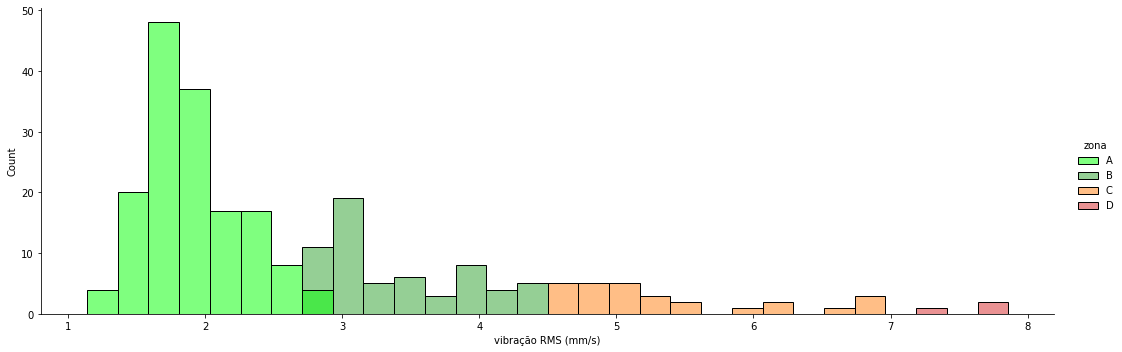

In [164]:
df_des_hor_max['zona'] = df_des_hor_max[VALUE].apply(zona_NBR10082)
df_des_hor_max = df_des_hor_max.sort_values(VALUE)

sns.displot(data=df_des_hor_max, x=VALUE, hue='zona', aspect=3, bins=30, palette=paleta);

In [165]:
df_des_ver_max.max()

desalinhamento vertical (mm)        1.9
rotação (Hz)                    60.9216
eixo                                tg2
vibração RMS (mm/s)             11.0992
zona                                  D
dtype: object

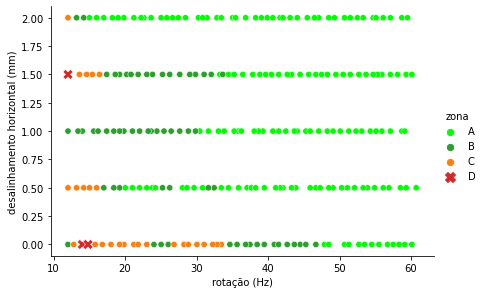

In [166]:
sns.relplot(
    data=df_des_hor_max.sort_values(VALUE), height=4, aspect=1.5,
    y=DESALINHAMENTO_HORIZONTAL, x=ROTACAO, size='zona', sizes=[40, 40, 40, 100], markers='oooX', style='zona',
    hue='zona', palette=paleta
);  

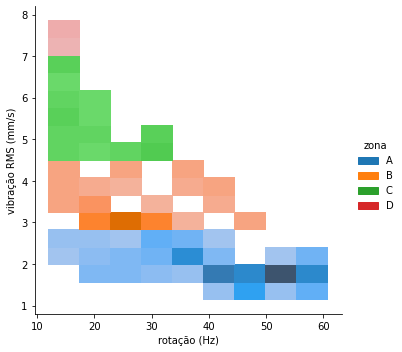

In [167]:
sns.displot(data=df_des_hor_max, hue='zona', y=VALUE, x=ROTACAO, cmap=paleta);

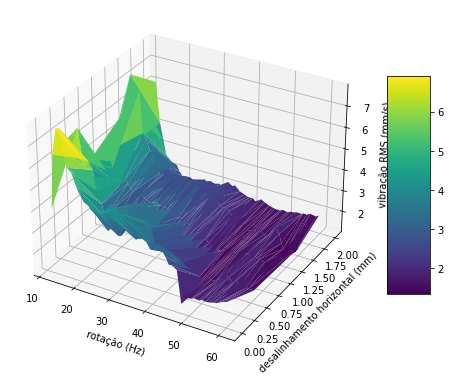

Nível de vibração RMS


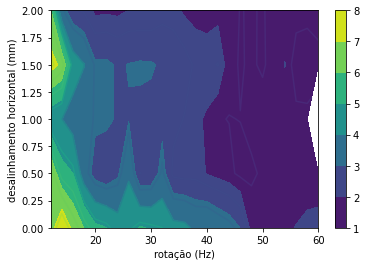

In [168]:
plot_surface(df_des_hor_max, DESALINHAMENTO_HORIZONTAL)
plota_niveis(df_des_hor_max, DESALINHAMENTO_HORIZONTAL)

In [152]:
def zona_NBR10082(valor_eficaz):
    # considerando equipamento Grupo II, suporte flexível
    if valor_eficaz < 2.8:
        return 'A'
    elif valor_eficaz < 4.5:
        return 'B'
    elif valor_eficaz < 7.1:
        return 'C'
    else:
        return 'D'

paleta = ['lime', 'tab:green', 'tab:orange', 'tab:red']

df_desbal_max['zona'] = df_desbal_max[VALUE].apply(zona_NBR10082)
df_desbal_max = df_desbal_max.sort_values(VALUE)

In [ ]:
for defect_name in [DE] 
    sns.displot(data=df_desbal_max, x=VALUE, hue='zona',
                aspect=3, bins=30);